In [43]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import seaborn as sns 

from PyPDF2 import PdfReader
import aspose.pdf as ap
import shutil

import re, string, os   
from wordcloud import WordCloud
import nltk 
from nltk.tokenize import word_tokenize


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score 
from sklearn.preprocessing import LabelEncoder 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, LSTM, GlobalAveragePooling1D, Dense, Dropout 
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model


# 1. Dataset Loading

In [2]:
resume = pd.read_csv("./Resume/Resume.csv")
resume.head()

ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR

# 2. Dropping Unnecessary Columns 

In [3]:
resume.drop(['ID', 'Resume_html'], axis=1, inplace=True)
resume.head() 

Resume_str Category
0           HR ADMINISTRATOR/MARKETING ASSOCIATE\...       HR
1           HR SPECIALIST, US HR OPERATIONS      ...       HR
2           HR DIRECTOR       Summary      Over 2...       HR
3           HR SPECIALIST       Summary    Dedica...       HR
4           HR MANAGER         Skill Highlights  ...       HR

# 3. Dataset Preview

In [4]:
# shape of the dataset 
print("Shape of the resume is :\n", resume.shape) 

Shape of the resume is :
 (2484, 2)


In [5]:
# information of the dataset 
resume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Resume_str  2484 non-null   object
 1   Category    2484 non-null   object
dtypes: object(2)
memory usage: 38.9+ KB


# 4. Dataset Cleaning

In [6]:
# Loading english stop words file
with open('./english_stopwords.txt', 'r', encoding='utf-8-sig') as f:
    stop_word = f.read() 
    stop_word = stop_word.replace(" ", "")
    stop_word = stop_word.split('\n')
    print(stop_word)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [7]:
# define nltk stemmer 
stemmer = nltk.stem.porter.PorterStemmer()

def clean_dataset(txt): 
    txt = txt.lower() 
    txt = re.sub('[^a-zA-Z]', ' ', txt)
    #txt = word_tokenize(txt)
    txt = txt.split() 
    #txt = [w for w in txt if not w in nltk.corpus.stopwords.words('english')]
    txt = [w for w in txt if not w in stop_word] 
    txt = [stemmer.stem(w) for w in txt]
    return ' '.join(txt)

def clean_labels(label): 
    txt = label.lower() 
    txt = txt.replace("-", "")
    txt = "".join(txt)   
    return txt 

# clean "Resume_str" features
resume['Resume_str'] = resume['Resume_str'].apply(lambda row: clean_dataset(row))

# clean "Category" features 
#resume['Category'] = resume['Category'].apply(lambda label: clean_dataset(label))
resume['Category'] = resume['Category'].apply(lambda label: clean_labels(label))
print("Shape of resume is :", resume.shape) 
resume.head() 

Shape of resume is : (2484, 2)


Resume_str Category
0  hr administr market associ hr administr summar...       hr
1  hr specialist us hr oper summari versatil medi...       hr
2  hr director summari year experi recruit plu ye...       hr
3  hr specialist summari dedic driven dynam year ...       hr
4  hr manag skill highlight hr skill hr depart st...       hr

# 5. Exploratory Data Analysis(EDA)

### 5.1 Total number of each category

In [9]:
# total counting of each class 
total_each_category = resume['Category'].value_counts() 
total_each_category

informationtechnology    120
businessdevelopment      120
finance                  118
advocate                 118
accountant               118
engineering              118
chef                     118
aviation                 117
fitness                  117
sales                    116
banking                  115
healthcare               115
consultant               115
construction             112
publicrelations          111
hr                       110
designer                 107
arts                     103
teacher                  102
apparel                   97
digitalmedia              96
agriculture               63
automobile                36
bpo                       22
Name: Category, dtype: int64

<AxesSubplot: >

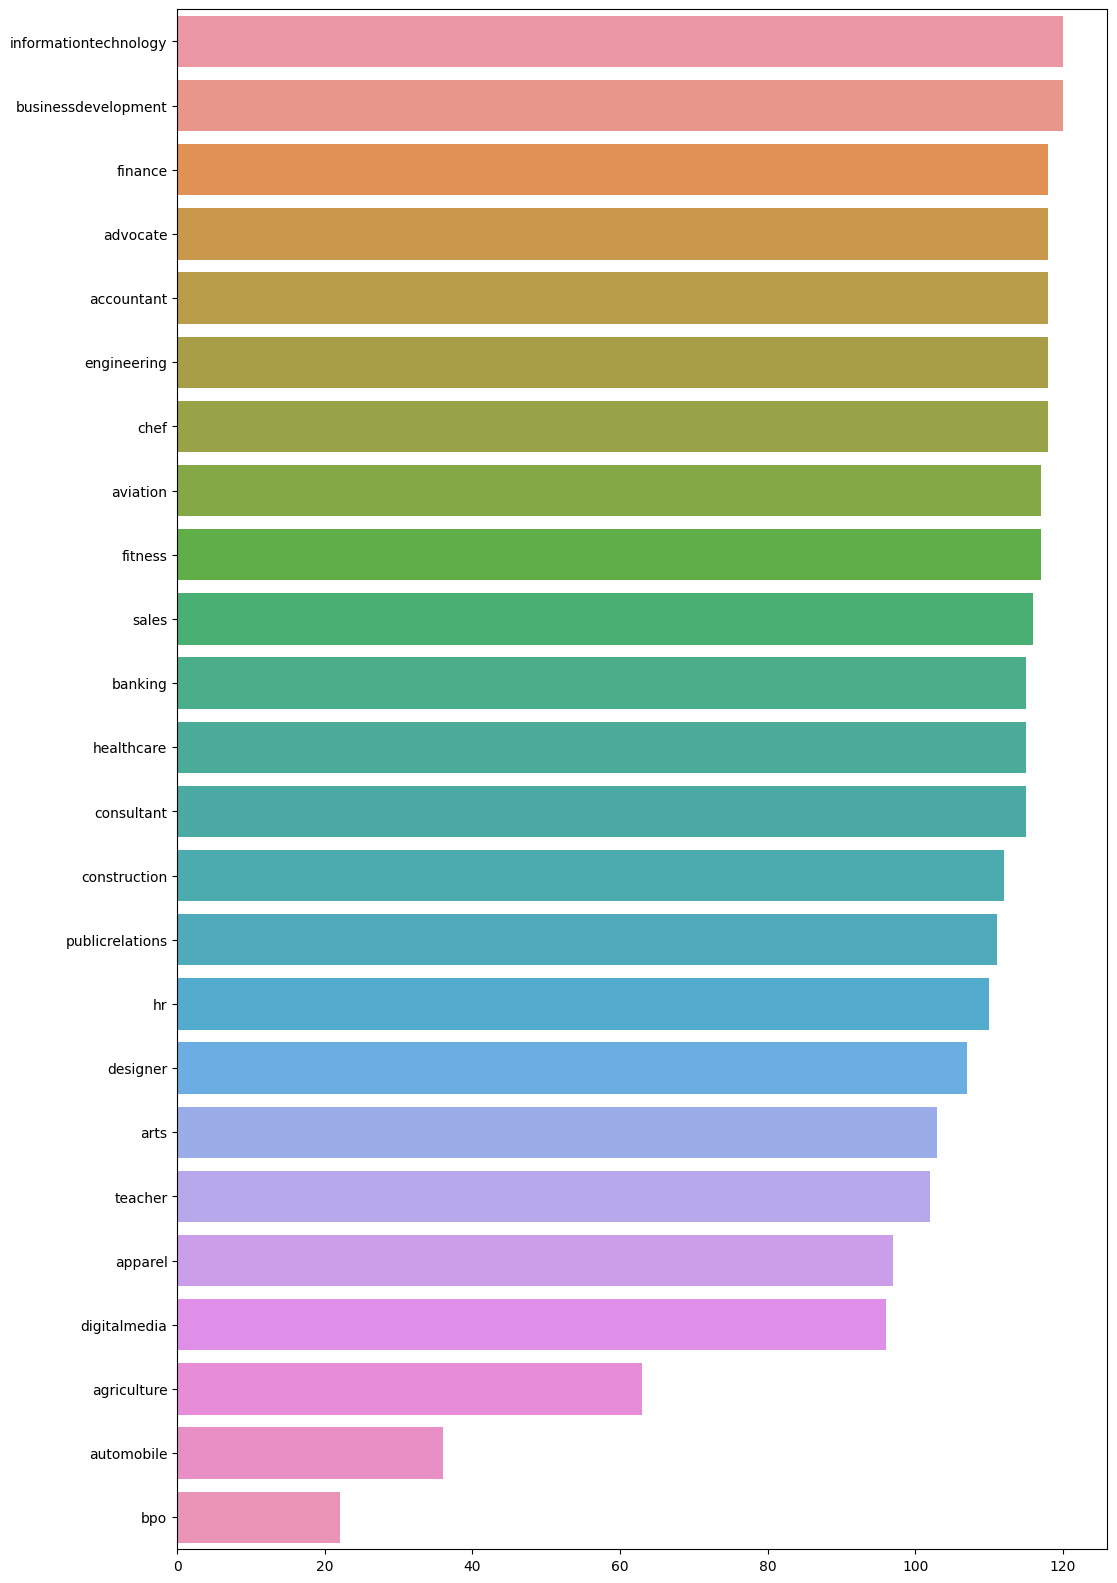

In [10]:
# Total number of each category in figure 
plt.figure(figsize=(12, 20)) 
sns.barplot(y=total_each_category.index, x=total_each_category.values) 

### 5.2 Percent of Each Category

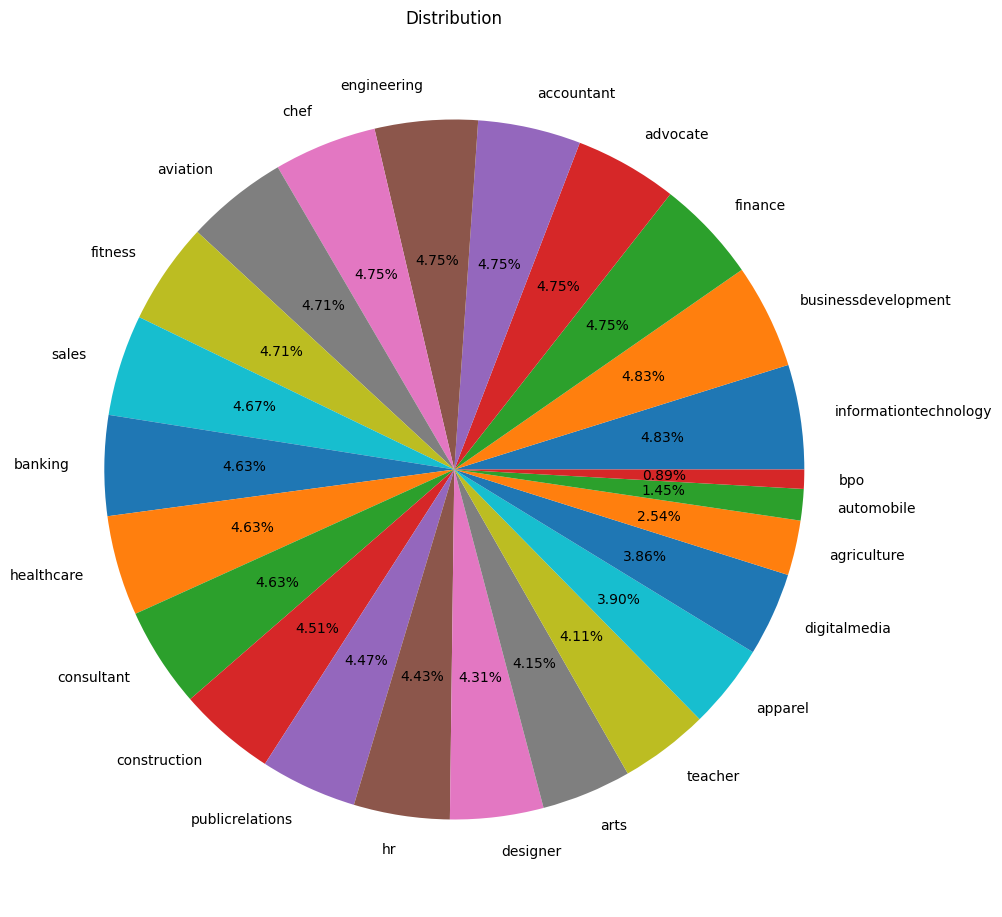

In [11]:
total_each_category_label = total_each_category.keys()

plt.figure(1, figsize=(25,25))
grid=GridSpec(2,2)

cmap=plt.get_cmap('coolwarm')

color=[cmap(i) for i in np.linspace(0, 1, 5)]
plt.subplot(grid[0,1], aspect=1, title='Distribution')

pie=plt.pie(total_each_category, labels=total_each_category_label, autopct='%1.2f%%')
plt.show()

### 5.3 Word Counting

In [12]:
# Average word in resume
resume_average = np.mean(resume['Resume_str'].apply(lambda x: len(x.split())))
print("Average word in resume is {}".format(resume_average))

# Minimum word in resume
resume_minimum = np.min(resume['Resume_str'].apply(lambda x: len(x.split())))
print("Minimum word in resume is {}".format(resume_minimum))

# Maximum word in resume 
resume_maximum = np.max(resume['Resume_str'].apply(lambda x: len(x.split())))
print("Maximum word in resume is {}".format(resume_maximum))

Average word in resume is 593.390499194847
Minimum word in resume is 0
Maximum word in resume is 3581


### 5.4 Most Common Words

In [13]:
all_data_array = resume['Resume_str'].values 
all_words = [] 
all_data = ""  

for row in all_data_array: 
    all_data += row 
    #tokenized_word = nltk.word_tokenize(row) 
    tokenized_word = row.split() 
    for word in tokenized_word: 
        if word not in stop_word and word not in string.punctuation:
            all_words.append(word) 

word_frequency = nltk.FreqDist(all_words) 
most_common_50_words = word_frequency.most_common(50) 
print(most_common_50_words)              

[('manag', 24408), ('state', 16805), ('compani', 15723), ('citi', 15128), ('develop', 12127), ('name', 11792), ('custom', 11777), ('servic', 9241), ('work', 8875), ('skill', 8802), ('account', 8655), ('sale', 8553), ('busi', 8175), ('project', 8073), ('product', 7516), ('train', 7284), ('system', 7266), ('team', 7156), ('process', 6916), ('commun', 6893), ('plan', 6524), ('client', 6516), ('new', 6410), ('market', 6253), ('report', 6206), ('provid', 6169), ('oper', 6152), ('includ', 6129), ('design', 6102), ('assist', 6066), ('maintain', 6005), ('experi', 5853), ('program', 5562), ('perform', 5441), ('support', 5147), ('offic', 5125), ('educ', 5111), ('inform', 4885), ('prepar', 4594), ('use', 4470), ('implement', 4436), ('respons', 4393), ('employe', 4391), ('profession', 4384), ('financi', 4363), ('administr', 4015), ('staff', 3977), ('time', 3968), ('creat', 3967), ('ensur', 3939)]


<AxesSubplot: >

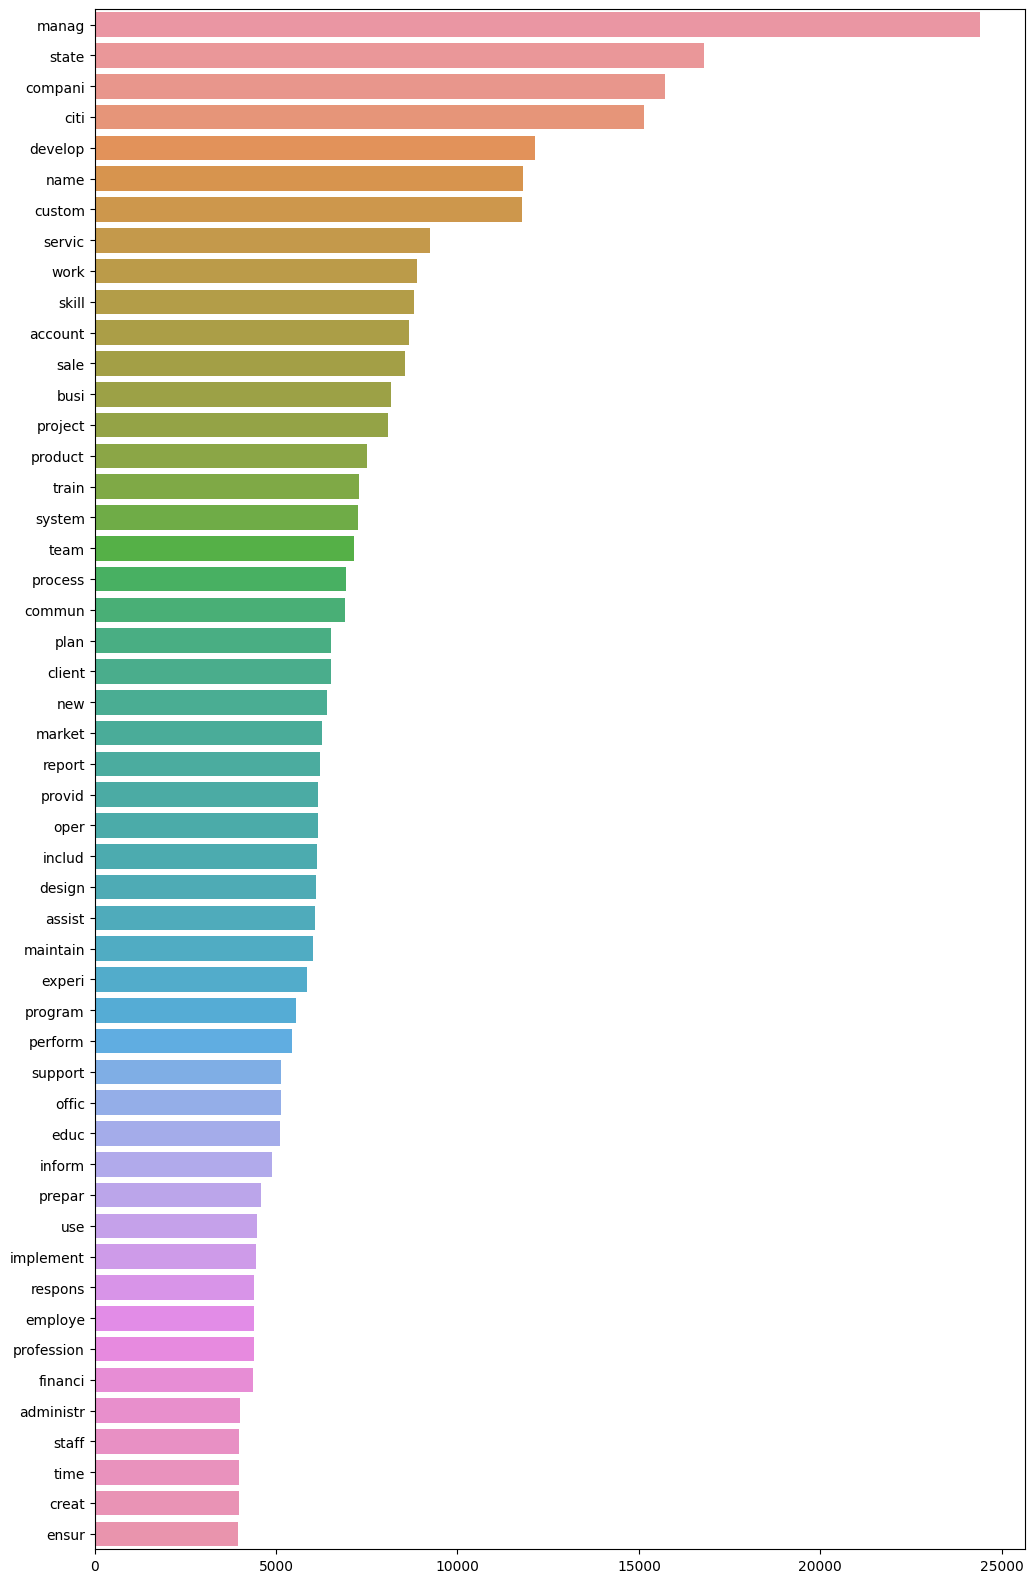

In [14]:
# Most common 50 words 
plt.figure(figsize=(12, 20)) 
sns.barplot(x=[tup[1] for tup in most_common_50_words], y=[tup[0] for tup in most_common_50_words])

### 5.5 WordCloud for all Words(dataset)

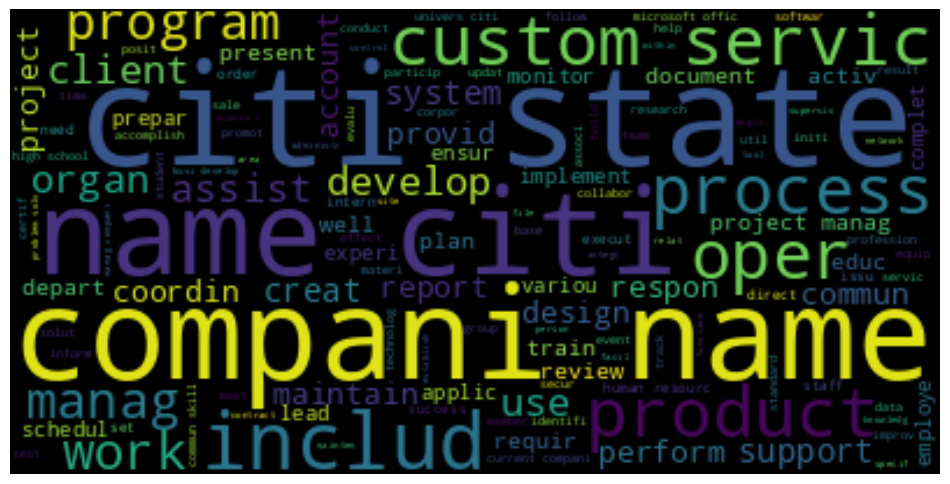

In [15]:
# word cloud
word_cloud = WordCloud().generate(all_data)
plt.figure(figsize=(12, 12))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show() 

### 5.6 Seperate Each Category

In [16]:
categories = np.sort(resume['Category'].unique()) 
resume_categories = [resume[resume['Category'] == category].loc[:, ['Resume_str', 'Category']] for category in categories]
print("Length of the resume_categories is: ", len(resume_categories))
resume_categories[0] 

Length of the resume_categories is:  24


Resume_str    Category
1808  account profession summari current account cit...  accountant
1809  account summari innov energet account profici ...  accountant
1810  account highlight microsoft offic intermedi mi...  accountant
1811  account profession summari inpati outpati reco...  accountant
1812  account summari pursu excel dynam busi world o...  accountant
...                                                 ...         ...
1921  gener account profession summari around year e...  accountant
1922  staff account profession summari current gradu...  accountant
1923  gener account summari year experienc professio...  accountant
1924  project account career focu dedic focus profes...  accountant
1925  senior account summari highli compet motiv rel...  accountant

[118 rows x 2 columns]

### 5.7 WordCloud for Each Category Class

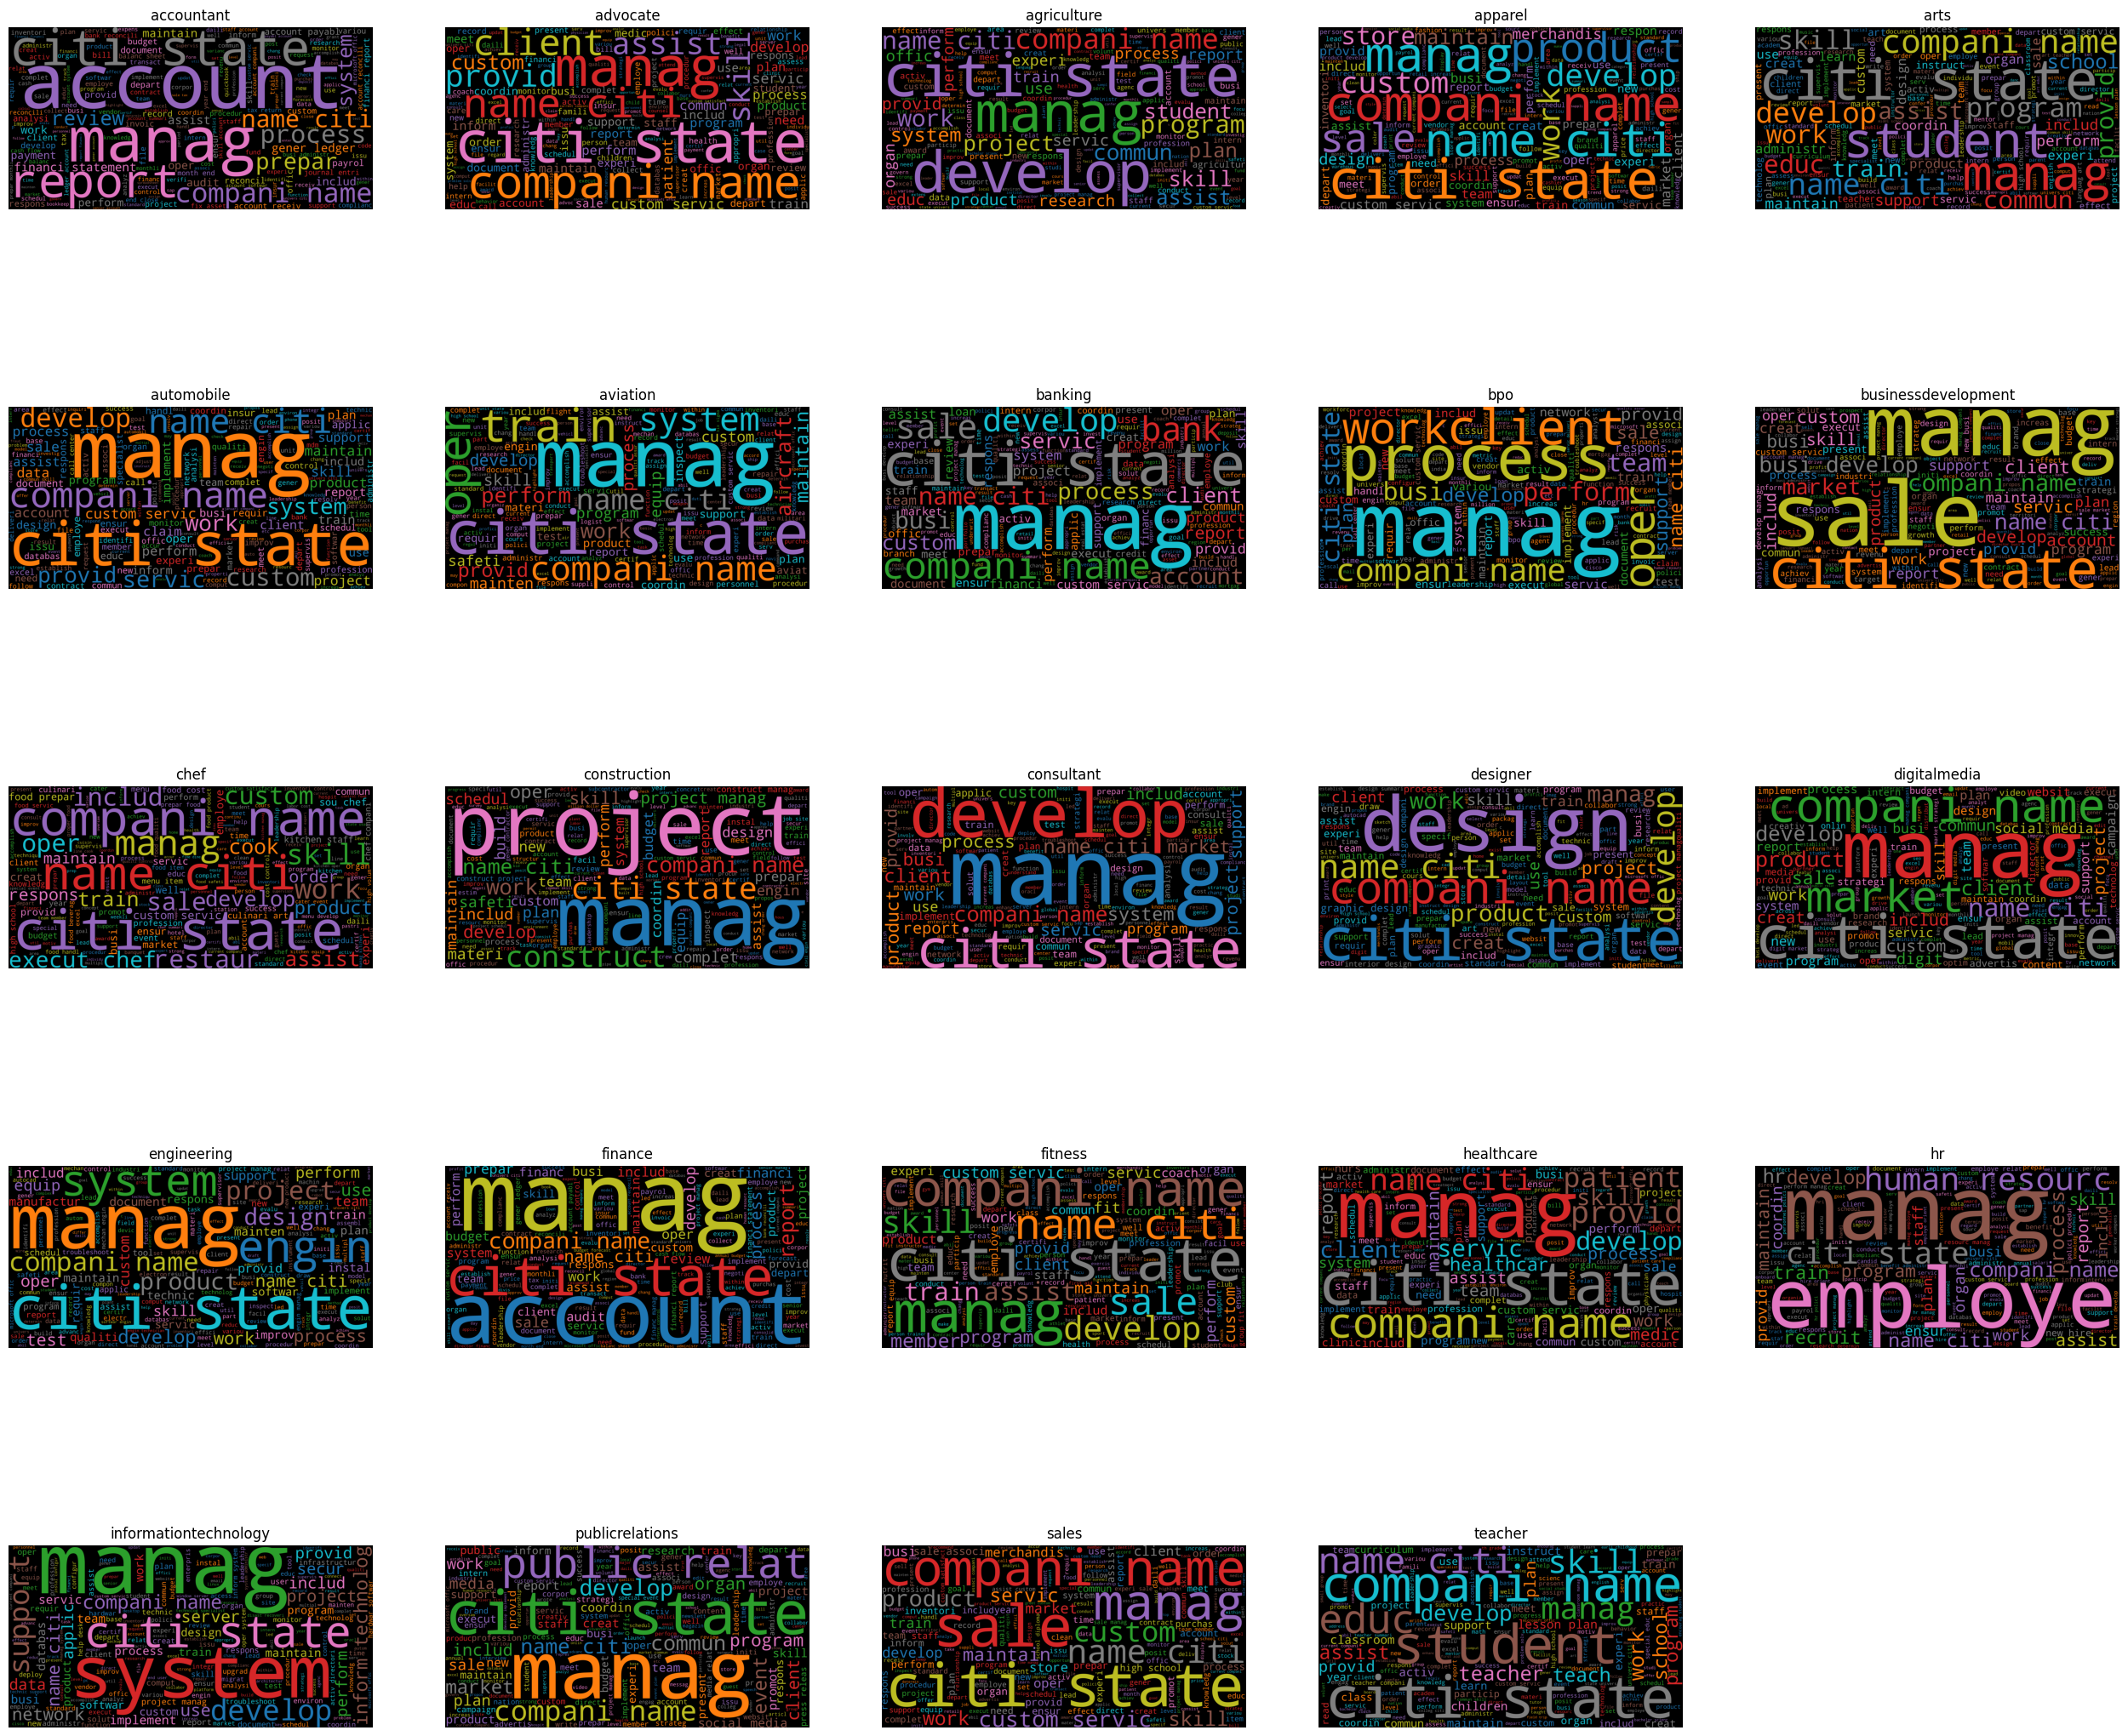

In [17]:
def word_cloud_function(catego): 
    def create_wordcloud(resume_categories):
        text = ' '.join(txt for txt in resume_categories['Resume_str']) 
        single_word_cloud = WordCloud(height=2000, width=4000, colormap='tab10_r').generate(text)
        return single_word_cloud 

    plt.figure(figsize=(32, 28))
    for i, category in enumerate(catego): 
        w_c = create_wordcloud(resume_categories[i]) 
        plt.subplot(5, 5, i+1).set_title(category) 
        plt.imshow(w_c)
        plt.axis('off')
        plt.plot() 
    plt.show() 
    plt.close() 

word_cloud_function(categories)

# 6. Word Frequency for each Category

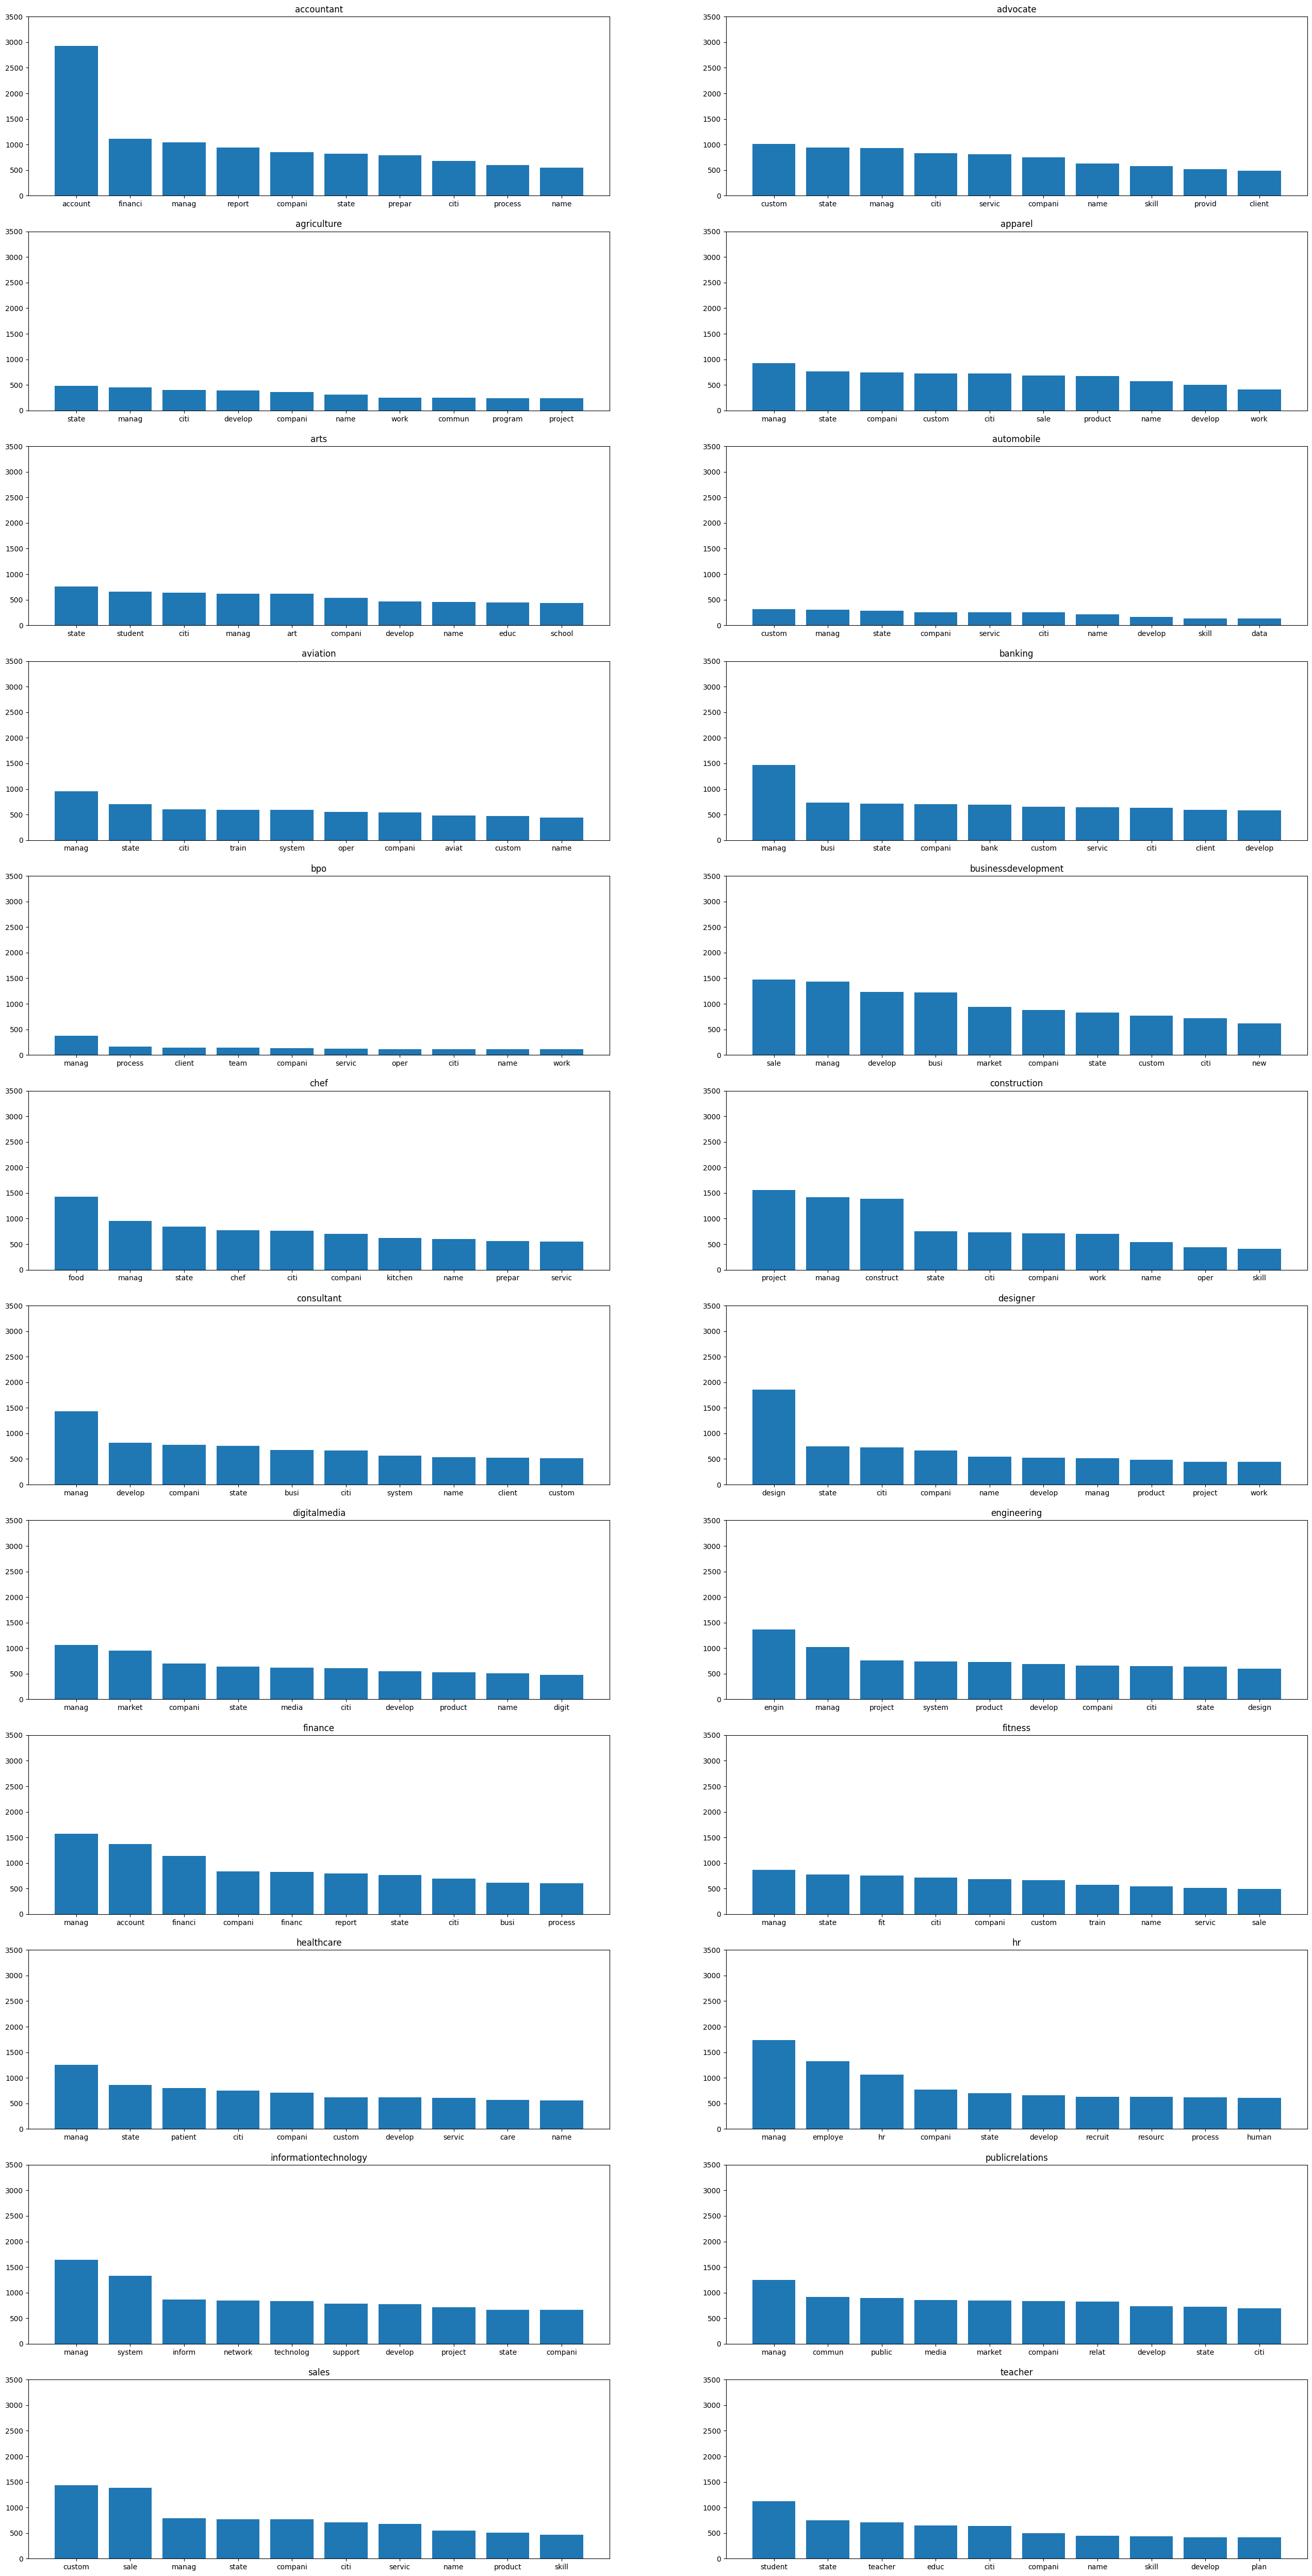

In [18]:
def word_frequency_function(categories, resume_categories): 
    def word_frequency(data_frame):
        count = data_frame['Resume_str'].str.split(expand=True).stack().value_counts().reset_index()
        count.columns = ['Word', 'Frequency'] 
        return count.head(10)

    fig = plt.figure(figsize=(32, 64))
    for i, category in enumerate(categories): 
        w_f = word_frequency(resume_categories[i]) 
        fig.add_subplot(12, 2, i + 1).set_title(category)
        plt.bar(w_f['Word'], w_f['Frequency']) 
        plt.ylim(0, 3500)
    plt.show() 
    plt.close() 

word_frequency_function(categories, resume_categories)

# 7. Feature Engineering

### 7.1 Number of Rows < 100 Words

In [8]:
rows_less_100_words = resume[resume['Resume_str'].apply(lambda x: len(x.split()) < 100 )]
print("Shape of rows_less_100_words is: {}".format(rows_less_100_words.shape)) 

Shape of rows_less_100_words is: (5, 2)


### 7.2 Drop Number of Rows <= 100 Words

In [9]:
resume = resume[resume['Resume_str'].apply(lambda x: len(x.split()) > 100)].reset_index(drop=True) 
print("Shape of resume is: {}".format(resume.shape)) 

Shape of resume is: (2479, 2)


# 8. Copy the data for later use

In [10]:
resume_copy = resume.copy()
print("Shape of resume_copy is: ", resume_copy.shape)
resume_copy.head() 

Shape of resume_copy is:  (2479, 2)


Resume_str Category
0  hr administr market associ hr administr summar...       hr
1  hr specialist us hr oper summari versatil medi...       hr
2  hr director summari year experi recruit plu ye...       hr
3  hr specialist summari dedic driven dynam year ...       hr
4  hr manag skill highlight hr skill hr depart st...       hr

# 9. Using Deep Learning

### 9.1 Label Encoding of the Category Column

In [11]:
def label_encoder_func(data): 
    le = LabelEncoder() 
    data['Category'] = le.fit_transform(data['Category'])

    le_classes = le.classes_
    le_inverse_trans = le.inverse_transform([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

    return data, le_classes, le_inverse_trans  

data = resume_copy.copy() 
df, le_classes, le_inverse_trans = label_encoder_func(data) 
print("Shape of df is :", df.shape)
print("Label encoder classes: ", le_classes)
print("Label encoder inverse transform: ", le_inverse_trans) 
df.head()  

Shape of df is : (2479, 2)
Label encoder classes:  ['accountant' 'advocate' 'agriculture' 'apparel' 'arts' 'automobile'
 'aviation' 'banking' 'bpo' 'businessdevelopment' 'chef' 'construction'
 'consultant' 'designer' 'digitalmedia' 'engineering' 'finance' 'fitness'
 'healthcare' 'hr' 'informationtechnology' 'publicrelations' 'sales'
 'teacher']
Label encoder inverse transform:  ['accountant' 'advocate' 'agriculture' 'apparel' 'arts' 'automobile'
 'aviation' 'banking' 'bpo' 'businessdevelopment' 'chef' 'construction'
 'consultant' 'designer' 'digitalmedia' 'engineering' 'finance' 'fitness'
 'healthcare' 'hr' 'informationtechnology' 'publicrelations' 'sales'
 'teacher']


Resume_str  Category
0  hr administr market associ hr administr summar...        19
1  hr specialist us hr oper summari versatil medi...        19
2  hr director summari year experi recruit plu ye...        19
3  hr specialist summari dedic driven dynam year ...        19
4  hr manag skill highlight hr skill hr depart st...        19

### 9.2 Dividing Dataset

In [12]:
# seperating features and labels 
X = df['Resume_str'].values 
y = df['Category'].values 

# dividing dataset 
X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=.1, shuffle=True, stratify=y, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=.1, shuffle=True, stratify=Y_train, random_state=42)
print("Shape of x_train is: ", x_train.shape)  
print("Shape of x_valid is: ", x_valid.shape) 
print("Shape of x_test is: ", x_test.shape) 
print("Shape of y_train is: ", y_train.shape) 
print("Shape of y_valid is: ", y_valid.shape) 
print("Shape of y_test is: ", y_test.shape)   

Shape of x_train is:  (2007,)
Shape of x_valid is:  (224,)
Shape of x_test is:  (248,)
Shape of y_train is:  (2007,)
Shape of y_valid is:  (224,)
Shape of y_test is:  (248,)


### 9.3 Tokenization and Pad Sequence for Features

In [13]:
# Define some variables 
embed_size = 300
max_features = 120000
max_len = 250

# join all list of features 
full_text = list(x_train) + list(x_valid) + list(x_test) 

# define tokenizer 
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(full_text) 

In [14]:
# Tokenizing
x_train = tokenizer.texts_to_sequences(x_train)
x_valid = tokenizer.texts_to_sequences(x_valid)
x_test = tokenizer.texts_to_sequences(x_test) 

# Pad sequences 
x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
x_valid = pad_sequences(x_valid, maxlen=max_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')  

### 9.4 Tokenization for Labels

In [15]:
# label_tokenizer = Tokenizer(lower=True) 
# label_tokenizer.fit_on_texts(y) 

# y_train = label_tokenizer.texts_to_sequences(y_train)
# y_valid = label_tokenizer.texts_to_sequences(y_valid) 
# y_test = label_tokenizer.texts_to_sequences(y_test)

# label_index = label_tokenizer.word_index
# print(dict(list(label_index.items())))

### 9.5 Convert to Numpy Array

In [16]:
# Features 
# x_train = np.array(x_train) 
# x_valid = np.array(x_valid)
# x_test = np.array(x_test) 

# # Labels
# y_train = np.array(y_train) 
# y_valid = np.array(y_valid) 
# y_test = np.array(y_test) 


In [17]:
# print(x_train.shape) 
# print(x_valid.shape) 
# print(x_test.shape) 

# print(y_train.shape) 
# print(y_valid.shape) 
# print(y_test.shape) 

### 9.6 Building Model_1 and Model_2

In [19]:
# Building model_1 with GRU 
input = Input(shape=(max_len,))   
x = Embedding(max_features, embed_size)(input)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalAveragePooling1D()(x) 
x = Dense(64, activation='relu')(x) 
x = Dropout(0.1)(x)
x = Dense(24, activation='softmax')(x) 

model_1 = Model(inputs=input, outputs=x)

2023-08-12 21:19:27.660098: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-12 21:19:27.660151: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (moni-asus-tuf-gaming-f15): /proc/driver/nvidia/version does not exist
2023-08-12 21:19:27.660798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# Building model_2 with LSTM 
# embedding_dim = 64

model_2 = Sequential([
  Embedding(max_features, embed_size, input_length=1),
  Bidirectional(LSTM(embed_size, return_sequences=True)),  
  GlobalAveragePooling1D(), 
  Dense(embed_size, activation='relu'), 
  Dropout(0.1), 
  Dense(24, activation='softmax')
]) 


2023-08-12 21:38:11.366034: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-12 21:38:11.366093: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (moni-asus-tuf-gaming-f15): /proc/driver/nvidia/version does not exist
2023-08-12 21:38:11.366915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
# printing model summary 
model_1.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding (Embedding)       (None, 250, 300)          36000000  
                                                                 
 bidirectional (Bidirectiona  (None, 250, 128)         140544    
 l)                                                              
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0     

In [22]:
# printing model_2 summary 
model_2.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1, 300)            36000000  
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 600)           1442400   
 nal)                                                            
                                                                 
 global_average_pooling1d_1   (None, 600)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 300)               180300    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_3 (Dense)             (None, 24)                7

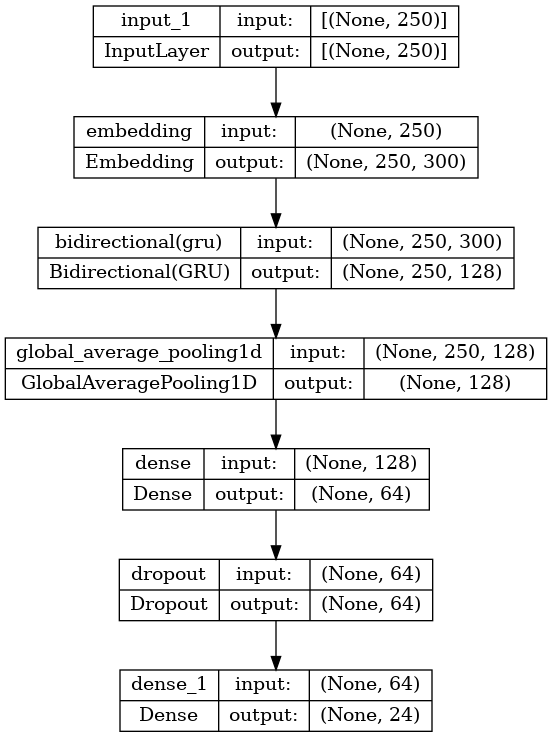

In [23]:
# plotting model_1 
plot_model(model_1, show_shapes=True, to_file = '/home/moni/interactive_cares/resume_classification_model_1.png')

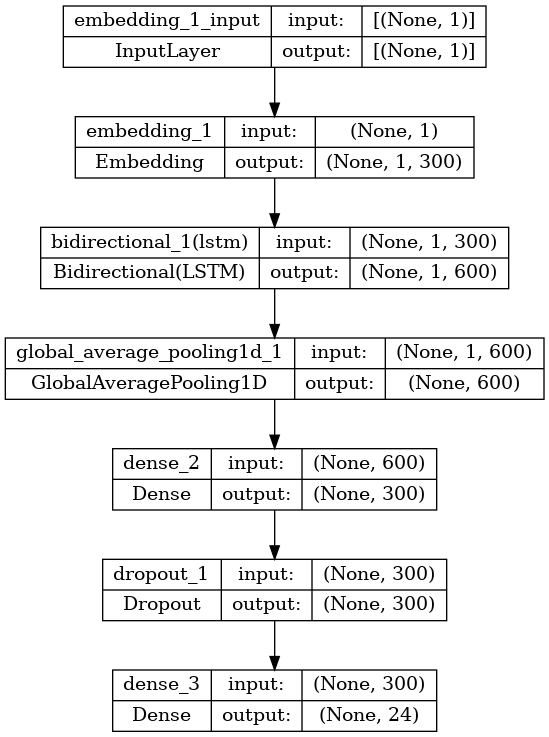

In [24]:
# plotting model_2 
plot_model(model_2, show_shapes=True, to_file = '/home/moni/interactive_cares/resume_classification_model_2.png')

In [25]:
# Compile model_1
model_1.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy']) 

In [19]:
# Compile model_2
model_2.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

### 9.7 Define checkpoints, reduceLR, EarlyStopping

In [27]:
# for model_1
checkpoints_1 = ModelCheckpoint('/home/moni/interactive_cares/weight_1.hdf5', 
                               monitor='val_loss', 
                               mode='max', 
                               verbose=True, 
                               save_best_only=True)

reduce_lr_1 = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=2, 
                              verbose=1, 
                              min_lr=0.000001)

early_stop_1 = EarlyStopping(monitor='val_loss', patience=3)

In [20]:
# for model_2
checkpoints_2 = ModelCheckpoint('/home/moni/interactive_cares/weight_2.hdf5', 
                               monitor='val_loss', 
                               mode='max', 
                               verbose=True, 
                               save_best_only=True)

reduce_lr_2 = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=2, 
                              verbose=1, 
                              min_lr=0.000001)

early_stop_2 = EarlyStopping(monitor='val_loss', patience=3)

### 9.8 Model Training

In [29]:
# Train model_1
history_1 = model_1.fit(x_train, y_train, 
          batch_size=512, 
          epochs=50, 
          validation_data=(x_valid, y_valid), 
          callbacks=[checkpoints_1, reduce_lr_1, early_stop_1])  

Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 3.1755 - accuracy: 0.0708
Epoch 1: val_loss improved from -inf to 3.16977, saving model to /home/moni/interactive_cares/weight_1.hdf5
4/4 [==============================] - 10s 2s/step - loss: 3.1755 - accuracy: 0.0708 - val_loss: 3.1698 - val_accuracy: 0.0848 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 3.1636 - accuracy: 0.1071
Epoch 2: val_loss did not improve from 3.16977
4/4 [==============================] - 7s 2s/step - loss: 3.1636 - accuracy: 0.1071 - val_loss: 3.1579 - val_accuracy: 0.1027 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 3.1477 - accuracy: 0.1340
Epoch 3: val_loss did not improve from 3.16977
4/4 [==============================] - 7s 2s/step - loss: 3.1477 - accuracy: 0.1340 - val_loss: 3.1410 - val_accuracy: 0.1161 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - ETA: 0s - loss: 3.1244 - accuracy: 0.1624
Epoch 4: val

In [21]:
# Train model_2
history_2 = model_2.fit(x_train, y_train, 
          batch_size=512, 
          epochs=50, 
          validation_data=(x_valid, y_valid), 
          callbacks=[checkpoints_2, reduce_lr_2, early_stop_2])  

Epoch 1/50


4/4 [==============================] - ETA: 0s - loss: 3.1737 - accuracy: 0.0613WARNING:tensorflow:Model was constructed with shape (None, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='embedding_input'), name='embedding_input', description="created by layer 'embedding_input'"), but it was called on an input with incompatible shape (None, 250).



Epoch 1: val_loss improved from -inf to 3.16179, saving model to /home/moni/interactive_cares/weight_2.hdf5
4/4 [==============================] - 50s 9s/step - loss: 3.1737 - accuracy: 0.0613 - val_loss: 3.1618 - val_accuracy: 0.0982 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 3.1443 - accuracy: 0.0907
Epoch 2: val_loss did not improve from 3.16179
4/4 [==============================] - 25s 6s/step - loss: 3.1443 - accuracy: 0.0907 - val_loss: 3.1061 - val_accuracy: 0.0982 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 3.0420 - accuracy: 0.1016
Epoch 3: val_loss did not improve from 3.16179
4/4 [==============================] - 24s 6s/step - loss: 3.0420 - accuracy: 0.1016 - val_loss: 3.0965 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - ETA: 0s - loss: 2.9890 - accuracy: 0.1151
Epoch 4: val_loss did not improve from 3.16179
4/4 [==============================] - 23s 6s/step - l

### 9.9 Model Evaluation

In [31]:
# model_1 evaluation 
print("Loss of the model_1 is {}".format(model_1.evaluate(x_valid, y_valid)[0]) )
print("Accuracy of the model_1 is {}%".format(model_1.evaluate(x_valid, y_valid)[1]*100 ))

7/7 [==============================] - 1s 54ms/step - loss: 2.3071 - accuracy: 0.3884
Loss of the model_1 is 2.3070905208587646
7/7 [==============================] - 0s 36ms/step - loss: 2.3071 - accuracy: 0.3884
Accuracy of the model_1 is 38.83928656578064%


In [32]:
# model_2 evaluation 
print("Loss of the model_2 is {}".format(model_2.evaluate(x_valid, y_valid)[0]) )
print("Accuracy of the model_2 is {}%".format(model_2.evaluate(x_valid, y_valid)[1]*100 ))

7/7 [==============================] - 1s 101ms/step - loss: 2.5893 - accuracy: 0.2589
Loss of the model_2 is 2.5893478393554688
7/7 [==============================] - 1s 103ms/step - loss: 2.5893 - accuracy: 0.2589
Accuracy of the model_2 is 25.89285671710968%


### 9.10 Accuracy and Loss of Train and Valid

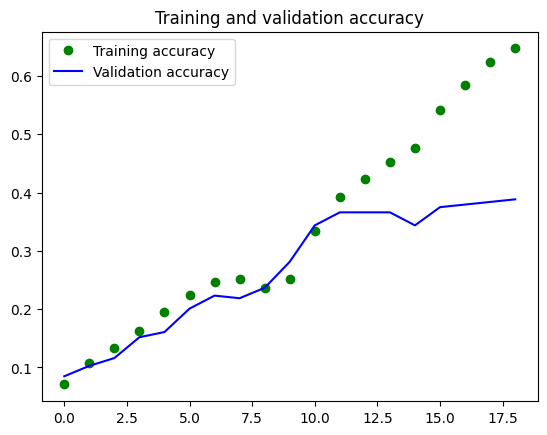

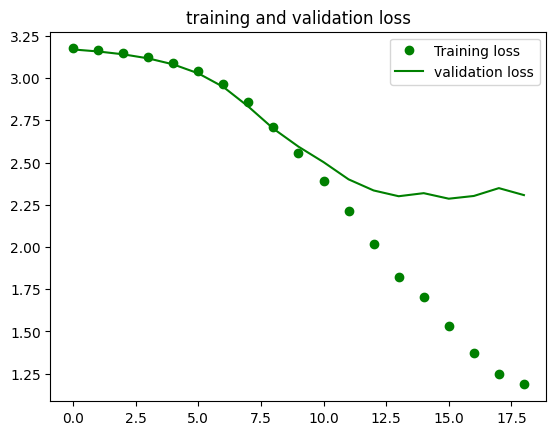

In [33]:
# for model_1
accuracy = history_1.history['accuracy']
val_accuracy = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(val_accuracy))
plt.plot(epochs, accuracy, 'go', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

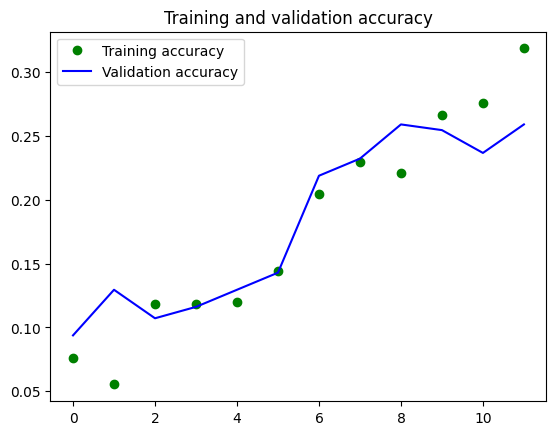

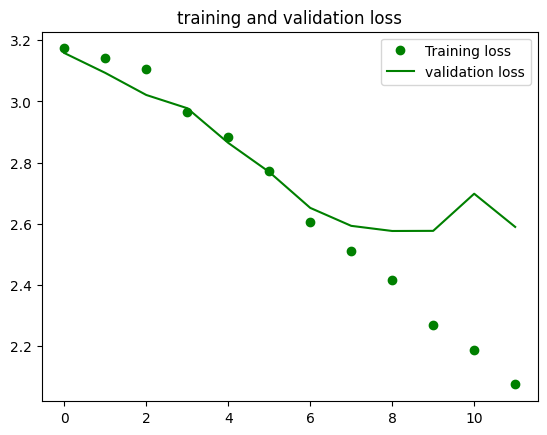

In [34]:
# for model_2
accuracy = history_2.history['accuracy']
val_accuracy = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(val_accuracy))
plt.plot(epochs, accuracy, 'go', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

### 9.11 Model Saving and Loading

In [35]:
# Manually saving full model_1 with h5 format 
model_1.save('/home/moni/interactive_cares/resume_classification_deep_learning_1.h5') 

# Loading full model_1 
loaded_model_1 = load_model('/home/moni/interactive_cares/resume_classification_deep_learning_1.h5') 

In [22]:
# Manually saving full model_2 with hdf5 format 
model_2.save('/home/moni/interactive_cares/resume_classification_deep_learning_2.h5') 

# Loading full model_2 
loaded_model_2 = load_model('/home/moni/interactive_cares/resume_classification_deep_learning_2.h5') 

### 9.12 Predicting with Test Data

In [24]:
# predict with test data with model_1
y_predicted_1 = loaded_model_1.predict(x_test)
y_predicted_1 = np.rint(y_predicted_1)
y_predicted_1 = np.argmax(y_predicted_1, axis=1) 
y_predicted_1 

8/8 [==============================] - 2s 34ms/step


array([ 0, 19,  0, 23, 21,  0, 11,  0,  0,  0,  0, 20,  0,  0,  0,  0, 21,
       14,  0,  0,  0, 20,  0,  0,  0,  0, 13,  0,  0, 11,  0,  0,  0, 13,
        0, 19,  0,  0,  0,  0,  0,  0,  0,  0, 14,  0,  0, 20,  0,  0, 15,
        0,  0,  0, 23,  0,  0,  0,  0, 20,  0,  0, 10,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 13, 10, 13,  0,  0,  0,  0,  0,  0,
        0, 13,  0, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0, 20,
        0,  0,  0,  0,  0,  0,  0,  0, 23,  0,  0, 14,  0,  0,  0,  0,  0,
        0,  0, 11,  0,  0, 15, 17,  0, 23,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 14,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,
       21,  0, 15,  0,  0, 23,  0,  0,  0, 23, 14, 14, 14, 10, 19, 17,  0,
        0,  0,  0,  0, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, 17, 17, 23, 14,  6,  0,  0,  0, 10,  0,  0, 20,  0,
        0,  0,  0, 13,  0,  0, 19, 20,  0,  0,  0, 21,  0,  0,  0, 20,  0,
        0,  0,  0, 10,  0

In [26]:
# predict with test data with model_2
y_predicted_2 = loaded_model_2.predict(x_test)
y_predicted_2 = np.rint(y_predicted_2)
y_predicted_2 = np.argmax(y_predicted_2, axis=1) 
y_predicted_2  

8/8 [==============================] - 1s 97ms/step


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 20,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 20,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 20,  0,
        0,  0,  0,  0,  0

### 9.13 Classification Report and Confusion Matrix

In [27]:
# classification report for model_1
print(classification_report(y_predicted_1, y_test))

              precision    recall  f1-score   support

           0       1.00      0.07      0.12       184
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.17      1.00      0.29         2
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.50      1.00      0.67         6
          11       0.27      0.60      0.37         5
          12       0.00      0.00      0.00         0
          13       0.27      0.50      0.35         6
          14       0.50      0.56      0.53         9
          15       0.33      0.80      0.47         5
          16       0.00      0.00      0.00         0
          17       0.33    

/home/moni/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/moni/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/moni/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# classification report for model_2 
print(classification_report(y_predicted_2, y_test))

              precision    recall  f1-score   support

           0       1.00      0.05      0.09       245
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

/home/moni/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/moni/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/moni/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot: >

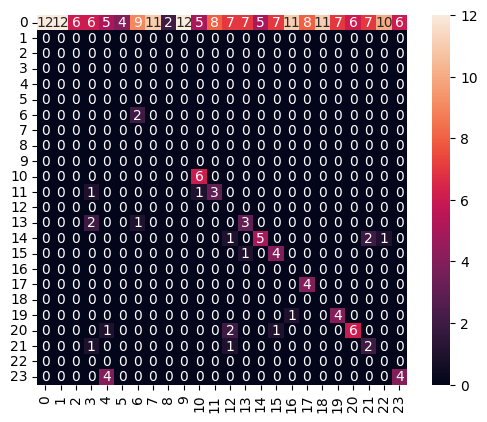

In [29]:
# Confusion matrix for model_1
confusion_matrix = confusion_matrix(y_predicted_1, y_test)
sns.heatmap(confusion_matrix, square=True, annot=True, fmt='d')  

### 9.14 Predicting with totally new data

In [36]:
encode_dict = {"accountant":0, "advocate":1, "agriculture":2, "apparel":3, "arts":4, "automobile":5, "aviation":6, "banking":7, "bpo":8, "businessdevelopment":9, "chef":10, "construction":11, "consultant":12, "designer":13, "digitalmedia":14, "engineering":15, "finance":16, "fitness":17, "healthcare":18, "hr":19, "informationtechnology":20, "publicrelations":21, "sales":22, "teacher":23} 


# prediction with model_1 
def predict_resume(model, text, max_len):
    #text cleaning
    text_cleaned = clean_dataset(text)

    # tokenizing and pad_sequences 
    text_token = tokenizer.texts_to_sequences([text_cleaned])
    text_pad = pad_sequences(text_token, padding='post', maxlen=max_len)
    
    pred = model.predict(text_pad)
    result = np.rint(pred)
    result = np.argmax(result, axis=1)
    result = list(encode_dict.keys())[list(encode_dict.values()).index(result[0])]

    return result

# New text 
text = "hr manag summari human resourc manag practic understand busi need area expertis includ conflict manag employe train human resourc generalist promot team orient open door environ conduc success staff offer number year experi knowledg train orient incent program creation level manag level human resourc execut work execut translat busi strategi hr action drive busi result nager year experi year manageri experi strong strateg plan peopl manag skill highlight compens payrol regulatori complianc staff develop compens benefit administr polici program develop salari structur compens analysi perform manag strategi interview expertis staf recruit profession hire retent train develop employe relat experi compani name citi state hr manag current sunningdal tech thailand co ltd type busi tool plastic inject compani name citi state hr admin manag respons report directli ceo transform hr administr role strateg busi partner includ work manag level drive key busi implement perform initi conduct extens analysi exist hr organ develop busi plan date polici procedur servic program oper direct hr function includ recruit hire practic benefit compens develop standard organiz model clarifi author respons learn develop provid guidanc learn develop manag team well set train system implement identifi area need attent improv ensur legal complianc monitor implement applic labor law requir conduct investig maintain record repres organ hear deal complex disciplinari grievanc hr issu use hr compani knowledg evidenc appropri decis make skill overse manag administr activ compani ensur work process maxim effici sekisui lec thailand co ltd esi rayong type busi pvb interlay film lamin glass compani name citi state gener administr asst chief one year break live abroad promot fulfil broad rang hr function includ purchas gener administr ensur meet compani goal human resourc handl play key role ensur success full spectrum hr oper system program recruit select manag recruit process effect effici manner maintain date recruit progress implement report process manpow concern coordin negoti liais employ advertis agent servic fee advertis recruit interview schedul conduct interview execut level arrang interview manag level manag orient program employe busi cultur train develop identifi key skill specialti skill propos train need accordingli respons develop maintain standard develop meet object continu improv depart oper develop strateg plan meet compani goal manag assign staff compens benefit monitor alert divis manag varianc concern issu compil data need annual salari review annual perform apprais analysi promot annual bonu improv implement perform measur develop supervis manag hr function generalist job assign divis manag purchas supervis manag purchas function oversea domest concern supervis lead procur group phase prepar purchas requisit initi approv issu purchas order accord compani polici negoti term condit job assign divis manag gener administr manageri overse administr activ compani ensur work process maxim effici contribut team effort accomplish relat result need supervis gener administr support serv gener resourc direct inquiri wide varieti requestor plan schedul project ensur time complet work close gener administr manag perform execut administr task support requestor intern extern coordin workflow maintain product work environ develop recommend administr process procedur assur effici work close administr manag coordin effort toward meet deadlin clarifi prioriti establish process schedul ensur requir submiss made accur time manner respond initi inquiri question regard purchas personnel facil administr special program etc explain polici answer question independ resolv problem wheneverfeas compani name gener manag hr director hr manag take respons conceptu spearhead new hr initi develop manag effect respons human resourc function well lead hr team full spectrum human resourc activ formul implement human resourc polici procedur line compani busi goal manag compens staff benefit programm includ leav manag develop implement perform apprais perform manag system level staff line compani object manag recruit select activ meet manpow requir depart assess short long term train need well plan direct train develop programm rais compet employe overse payrol administr submit necessari statutori report relev author handl grievanc disciplinari matter plan carri compani event foster harmoni work environ conduct exit interview analys turnov determin implement appropri correct action overse manag administr activ compani ensur work process maxim effici type busi steel metal worksheet educ master public administr nation institut develop administr nida comprehens english cours cultur exchang program citi state usa bachelor educ chulalongkorn univers accomplish complet ongo train area human resourc manag pm apm certif cours analyt problem solv prevent tax iso ts iso requir leadership compet work perform apprais labor law balanc scorecard kpi happi work place welfar salari structur recruit compens benefit correct prevent action report analysi techniqu safeti supervisor level softwar expertis effici ms offic packag surf internet skill administr administr support advertis set benefit busi plan clarifi good commun skill interperson skill continu improv decis make english film hire human resourc hr law legal complianc manageri manag exchang organiz payrol perform apprais perform manag personnel polici process procur progress promot speak purchas requisit purchas recruit recruit report schedul strateg strateg plan type workflow"

# Calling the function to predict the text 
prediction = predict_resume(loaded_model_1, text, max_len) 
print("Prediction after testing for model_1: ", prediction) 

1/1 [==============================] - 0s 44ms/step
Prediction after testing for model_1:  hr


In [37]:
encode_dict = {"accountant":0, "advocate":1, "agriculture":2, "apparel":3, "arts":4, "automobile":5, "aviation":6, "banking":7, "bpo":8, "businessdevelopment":9, "chef":10, "construction":11, "consultant":12, "designer":13, "digitalmedia":14, "engineering":15, "finance":16, "fitness":17, "healthcare":18, "hr":19, "informationtechnology":20, "publicrelations":21, "sales":22, "teacher":23} 

# prediction with model_2  
def predict_resume(model, text, max_len):
    #text cleaning
    text_cleaned = clean_dataset(text)

    # tokenizing and pad_sequences 
    text_token = tokenizer.texts_to_sequences([text_cleaned])
    text_pad = pad_sequences(text_token, padding='post', maxlen=max_len)
    
    pred = model.predict(text_pad)
    result = np.rint(pred)
    result = np.argmax(result, axis=1)
    result = list(encode_dict.keys())[list(encode_dict.values()).index(result[0])]

    return result 

# New text 
text = "hr manag summari human resourc manag practic understand busi need area expertis includ conflict manag employe train human resourc generalist promot team orient open door environ conduc success staff offer number year experi knowledg train orient incent program creation level manag level human resourc execut work execut translat busi strategi hr action drive busi result nager year experi year manageri experi strong strateg plan peopl manag skill highlight compens payrol regulatori complianc staff develop compens benefit administr polici program develop salari structur compens analysi perform manag strategi interview expertis staf recruit profession hire retent train develop employe relat experi compani name citi state hr manag current sunningdal tech thailand co ltd type busi tool plastic inject compani name citi state hr admin manag respons report directli ceo transform hr administr role strateg busi partner includ work manag level drive key busi implement perform initi conduct extens analysi exist hr organ develop busi plan date polici procedur servic program oper direct hr function includ recruit hire practic benefit compens develop standard organiz model clarifi author respons learn develop provid guidanc learn develop manag team well set train system implement identifi area need attent improv ensur legal complianc monitor implement applic labor law requir conduct investig maintain record repres organ hear deal complex disciplinari grievanc hr issu use hr compani knowledg evidenc appropri decis make skill overse manag administr activ compani ensur work process maxim effici sekisui lec thailand co ltd esi rayong type busi pvb interlay film lamin glass compani name citi state gener administr asst chief one year break live abroad promot fulfil broad rang hr function includ purchas gener administr ensur meet compani goal human resourc handl play key role ensur success full spectrum hr oper system program recruit select manag recruit process effect effici manner maintain date recruit progress implement report process manpow concern coordin negoti liais employ advertis agent servic fee advertis recruit interview schedul conduct interview execut level arrang interview manag level manag orient program employe busi cultur train develop identifi key skill specialti skill propos train need accordingli respons develop maintain standard develop meet object continu improv depart oper develop strateg plan meet compani goal manag assign staff compens benefit monitor alert divis manag varianc concern issu compil data need annual salari review annual perform apprais analysi promot annual bonu improv implement perform measur develop supervis manag hr function generalist job assign divis manag purchas supervis manag purchas function oversea domest concern supervis lead procur group phase prepar purchas requisit initi approv issu purchas order accord compani polici negoti term condit job assign divis manag gener administr manageri overse administr activ compani ensur work process maxim effici contribut team effort accomplish relat result need supervis gener administr support serv gener resourc direct inquiri wide varieti requestor plan schedul project ensur time complet work close gener administr manag perform execut administr task support requestor intern extern coordin workflow maintain product work environ develop recommend administr process procedur assur effici work close administr manag coordin effort toward meet deadlin clarifi prioriti establish process schedul ensur requir submiss made accur time manner respond initi inquiri question regard purchas personnel facil administr special program etc explain polici answer question independ resolv problem wheneverfeas compani name gener manag hr director hr manag take respons conceptu spearhead new hr initi develop manag effect respons human resourc function well lead hr team full spectrum human resourc activ formul implement human resourc polici procedur line compani busi goal manag compens staff benefit programm includ leav manag develop implement perform apprais perform manag system level staff line compani object manag recruit select activ meet manpow requir depart assess short long term train need well plan direct train develop programm rais compet employe overse payrol administr submit necessari statutori report relev author handl grievanc disciplinari matter plan carri compani event foster harmoni work environ conduct exit interview analys turnov determin implement appropri correct action overse manag administr activ compani ensur work process maxim effici type busi steel metal worksheet educ master public administr nation institut develop administr nida comprehens english cours cultur exchang program citi state usa bachelor educ chulalongkorn univers accomplish complet ongo train area human resourc manag pm apm certif cours analyt problem solv prevent tax iso ts iso requir leadership compet work perform apprais labor law balanc scorecard kpi happi work place welfar salari structur recruit compens benefit correct prevent action report analysi techniqu safeti supervisor level softwar expertis effici ms offic packag surf internet skill administr administr support advertis set benefit busi plan clarifi good commun skill interperson skill continu improv decis make english film hire human resourc hr law legal complianc manageri manag exchang organiz payrol perform apprais perform manag personnel polici process procur progress promot speak purchas requisit purchas recruit recruit report schedul strateg strateg plan type workflow"

# Calling the function to predict the text 
prediction = predict_resume(loaded_model_2, text, max_len)
print("Prediction after testing for model_2: ", prediction) 

1/1 [==============================] - 0s 36ms/step
Prediction after testing for model_2:  accountant


### 9.15 Tenosrflow Model to TFLite Model

In [ ]:
# saved model path
# tf_model_path = "/home/moni/interactive_cares/saved_model"
# model = tf.saved_model.load(tf_model_path)

# convert tensorflow model to tflite model 
# converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)  
# tflite_model = converter.convert() 

# save tflite model
# tf.io.write_file("./tflite_nn_model_1.h5", tflite_model)  

# script.py file code

In [44]:
# define nltk stemmer  and tokenizer 
stemmer = nltk.stem.porter.PorterStemmer()
tokenizer = Tokenizer(num_words=120000) 

# Loading english stop words file
with open('./english_stopwords.txt', 'r', encoding='utf-8-sig') as f:
    stop_word = f.read() 
    stop_word = stop_word.replace(" ", "")
    stop_word = stop_word.split('\n')
    #print(stop_word)

# data cleaning function 
def clean_dataset(txt): 
    txt = txt.lower() 
    txt = re.sub('[^a-zA-Z]', ' ', txt)
    #txt = word_tokenize(txt)
    txt = txt.split() 
    #txt = [w for w in txt if not w in nltk.corpus.stopwords.words('english')]
    txt = [w for w in txt if not w in stop_word] 
    txt = [stemmer.stem(w) for w in txt]
    return ' '.join(txt)

# main function for prediction ml model, making pdf file and categorize, creating csv file  
def reading_multiple_pdf_file(main_path, model, encode_dict):
     # making a directory for storing created pdf file and csv file
     output_dir_path = "./output_data"
     if os.path.exists(output_dir_path): 
          shutil.rmtree(output_dir_path) 
     os.mkdir(output_dir_path)  

     # a dictionary for creating csv file 
     data_dict = {"filename": [], "category": [] } 

     resume_categories = os.listdir(main_path)
     # traverse each category 
     for cate in resume_categories:
          resume_cate_path = os.path.join(main_path, cate)  
          resume_pdf_list = os.listdir(resume_cate_path)

          # traversing each resume of a specific category 
          for pdf in resume_pdf_list:
               str = '' 
               resume_full_path = os.path.join(resume_cate_path, pdf)

               # Reading each page of pdf file
               reader = PdfReader(resume_full_path) 
               pdf_page_length = len(reader.pages) 
               for pag in range(0, pdf_page_length): 
                    page = reader.pages[pag]  
                    text = page.extract_text() 
                    str += text 
               
               # data cleaning  
               text = clean_dataset(str)
               # Tokenizer and pad sequence 
               text_token = tokenizer.texts_to_sequences([text]) 
               text_pad = pad_sequences(text_token, padding='post', maxlen=250)
               # predict with ML model
               prediction = model.predict(text_pad) 
               prediction = np.rint(prediction)
               prediction = np.argmax(prediction, axis=1) 
               result = list(encode_dict.keys())[list(encode_dict.values()).index(prediction[0])]

                    
               # making dictionary for csv file 
               data_dict['filename'].append(pdf) 
               data_dict['category'].append(result)   

               # making pdf file for saving in a folder 
               document = ap.Document() 
               page = document.pages.add() 
               text = ap.text.TextFragment(str) 
               page.paragraphs.add(text)

               #  categorize pdf file 
               if not os.path.exists(os.path.join("./output_data/", result)): 
                    os.mkdir(os.path.join("./output_data", result))
               else:
                    document.save(os.path.join("./output_data", result, pdf))  
               
          str = "" 
     # making csv file. Save csv file into directory
     df = pd.DataFrame(data_dict)
     df.to_csv("./output_data/categorized_resume.csv", index=False)
     return df  


       
encode_dict = {"accountant":0, "advocate":1, "agriculture":2, "apparel":3, "arts":4, "automobile":5, "aviation":6, "banking":7, "bpo":8, "businessdevelopment":9, "chef":10, "construction":11, "consultant":12, "designer":13, "digitalmedia":14, "engineering":15, "finance":16, "fitness":17, "healthcare":18, "hr":19, "informationtechnology":20, "publicrelations":21, "sales":22, "teacher":23} 
loaded_model = load_model("./resume_classification_deep_learning_1.h5")      

pdf_main_path = "./input_data/"
df = reading_multiple_pdf_file(pdf_main_path, loaded_model, encode_dict) 

1/1 [==============================] - 0s 20ms/step


In [45]:
df 

filename    category
0    accountant_1.pdf  accountant
1    accountant_2.pdf  accountant
2    accountant_3.pdf  accountant
3   agriculture_3.pdf  accountant
4   agriculture_2.pdf  accountant
5   agriculture_1.pdf  accountant
6      advocate_2.pdf  accountant
7      advocate_1.pdf  accountant
8      advocate_3.pdf  accountant
9          arts_3.pdf  accountant
10         arts_1.pdf  accountant
11         arts_2.pdf  accountant
12      apparel_2.pdf  accountant
13      apparel_1.pdf  accountant
14      apparel_3.pdf  accountant

## 10. Using Scikit-Learn Classification Algorithm

### 10.1 Label Encoding

In [14]:
# define encoding function 
def label_encoder_func(df): 
    le = LabelEncoder() 
    df['Category'] = le.fit_transform(df['Category'])

    return df 

data_frame = resume_copy.copy() 
df = label_encoder_func(data_frame)
print("Shape of df is :", df.shape)
df.head()  

Shape of df is : (2479, 2)


Resume_str  Category
0  hr administr market associ hr administr summar...        19
1  hr specialist us hr oper summari versatil medi...        19
2  hr director summari year experi recruit plu ye...        19
3  hr specialist summari dedic driven dynam year ...        19
4  hr manag skill highlight hr skill hr depart st...        19

### 10.2 Dividing Dataset

In [15]:
# define function for dividing dataset 
def divide_dataset_func(df): 

    X = df['Resume_str'].values 
    y = df['Category'].values 

    # Vectorizing 
    vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words='english')
    vectorizer.fit(X)
    features = vectorizer.transform(X) 

    # Dividing dataset
    x_train, x_test, y_train, y_test = train_test_split(features, y, test_size=.1, shuffle=True, stratify=y, random_state=42)
    # x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=.1, shuffle=True, stratify=Y_train, random_state=42)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = divide_dataset_func(df)
print("Shape of x_train is: {} \nShape of x_test is: {} \nShape of y_train is: {} \nShape of y_test is: {}".format(x_train.shape, x_test.shape, y_train.shape, y_test.shape))    

Shape of x_train is: (2231, 26668) 
Shape of x_test is: (248, 26668) 
Shape of y_train is: (2231,) 
Shape of y_test is: (248,)


### 10.3 Using KNeighborsClassifier Model

In [16]:
def using_knn_classifier(x_train, y_train, x_test, y_test): 
    knn_classifier = OneVsRestClassifier(KNeighborsClassifier())
    knn_classifier.fit(x_train, y_train) 

    # prediction with test data
    y_predict_knn = knn_classifier.predict(x_test)

    # Training data accuracy 
    acc_train_data_knn = round(knn_classifier.score(x_train, y_train)*100) 

    # Test data accuracy 
    acc_test_data_knn = round(accuracy_score(y_predict_knn, y_test)*100)  
    
    # classification report
    classifi_report_knn = classification_report(y_predict_knn, y_test)

    return acc_train_data_knn, acc_test_data_knn, y_predict_knn, classifi_report_knn

acc_train_data_knn, acc_test_data_knn, y_predict_knn, classifi_report_knn = using_knn_classifier(x_train, y_train, x_test, y_test)

/home/moni/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/moni/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/moni/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# train, test accuracy and classification report 
print("Train accuracy: ", acc_train_data_knn)
print("Test accuracy: ", acc_test_data_knn) 
print("Classification report: \n",classifi_report_knn) 

Train accuracy:  65
Test accuracy:  54
Classification report: 
               precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.25      0.38      0.30         8
           2       0.50      1.00      0.67         3
           3       0.20      0.40      0.27         5
           4       0.40      0.50      0.44         8
           5       0.25      1.00      0.40         1
           6       0.50      0.60      0.55        10
           7       0.45      0.83      0.59         6
           8       0.00      0.00      0.00         0
           9       0.42      0.56      0.48         9
          10       0.50      1.00      0.67         6
          11       0.91      0.71      0.80        14
          12       0.00      0.00      0.00         4
          13       0.45      0.83      0.59         6
          14       0.60      0.60      0.60        10
          15       0.58      0.70      0.64        10
          16     

### 10.4 Using Multinomial Naive Bayes

In [18]:
def define_multinomial_nb_func(x_train, y_train, x_test, y_test):   
    nb = Pipeline([
                ('clf', MultinomialNB())
                ])
    nb.fit(x_train, y_train)

    # predict with test data 
    y_predict_nb = nb.predict(x_test) 

    # train accuracy and test accuracy 
    train_accuracy_nb = round(nb.score(x_train, y_train)*100)
    test_accuracy_nb =round(accuracy_score(y_predict_nb, y_test)*100)

    # classification report
    classifi_report_nb = classification_report(y_predict_nb, y_test)

    return train_accuracy_nb, test_accuracy_nb, y_predict_nb, classifi_report_nb

train_accuracy_nb, test_accuracy_nb, y_predict_nb, classifi_report_nb = define_multinomial_nb_func(x_train, y_train, x_test, y_test)

/home/moni/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/moni/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/moni/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# train, test accuracy and classification report 
print("Train accuracy: ", train_accuracy_nb) 
print("Test accuracy: ", test_accuracy_nb) 
print("Classification report: \n", classifi_report_nb)

Train accuracy:  66
Test accuracy:  50
Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.44      0.59        25
           1       0.42      0.29      0.34        17
           2       0.17      1.00      0.29         1
           3       0.10      1.00      0.18         1
           4       0.10      0.50      0.17         2
           5       0.00      0.00      0.00         0
           6       0.58      0.64      0.61        11
           7       0.55      0.86      0.67         7
           8       0.00      0.00      0.00         0
           9       0.83      0.32      0.47        31
          10       0.58      0.70      0.64        10
          11       0.55      0.50      0.52        12
          12       0.00      0.00      0.00         0
          13       0.18      0.67      0.29         3
          14       0.00      0.00      0.00         0
          15       0.58      0.78      0.67         9
          16     

### 10.5 Using Decision Tree classifier

In [20]:
def define_decision_tree_classifier(x_train, y_train, x_test, y_test):   
    dtc = Pipeline([
                ('dtc', DecisionTreeClassifier()),
               ])
    dtc.fit(x_train, y_train)

     # predict with test data 
    y_predict_dtc = dtc.predict(x_test) 

    # train accuracy and test accuracy 
    train_accuracy_dtc = round(dtc.score(x_train, y_train)*100)
    test_accuracy_dtc = round(accuracy_score(y_predict_dtc, y_test)*100)

    # classification report
    classifi_report_dtc = classification_report(y_predict_dtc, y_test)

    return train_accuracy_dtc, test_accuracy_dtc, y_predict_dtc, classifi_report_dtc

train_accuracy_dtc, test_accuracy_dtc, y_predict_dtc, classifi_report_dtc = define_decision_tree_classifier(x_train, y_train, x_test, y_test)

In [21]:
# train, test accuracy and classification report 
print("Train accuracy: ", train_accuracy_dtc) 
print("Test accuracy: ", test_accuracy_dtc) 
print("Classification report: \n", classifi_report_dtc)

Train accuracy:  100
Test accuracy:  53
Classification report: 
               precision    recall  f1-score   support

           0       0.58      0.50      0.54        14
           1       0.75      0.64      0.69        14
           2       0.33      0.67      0.44         3
           3       0.50      0.38      0.43        13
           4       0.20      0.15      0.17        13
           5       0.00      0.00      0.00         2
           6       0.58      0.88      0.70         8
           7       0.36      0.44      0.40         9
           8       0.00      0.00      0.00         1
           9       0.33      0.33      0.33        12
          10       0.75      0.82      0.78        11
          11       0.73      0.67      0.70        12
          12       0.18      0.22      0.20         9
          13       0.45      0.50      0.48        10
          14       0.60      0.46      0.52        13
          15       0.67      0.67      0.67        12
          16    

### 10.6 Using Random Forest Classifier

In [24]:
def define_random_forest_classifier(x_train, y_train, x_test, y_test):   
    rfc = Pipeline([
                ('rfc', RandomForestClassifier(n_estimators=100)),
               ]) 
    rfc.fit(x_train, y_train)

    # predict with test data 
    y_predict_rfc = rfc.predict(x_test) 

    # train accuracy and test accuracy 
    train_accuracy_rfc = round(rfc.score(x_train, y_train)*100)
    test_accuracy_rfc =round(accuracy_score(y_predict_rfc, y_test)*100)

    # classification report
    classifi_report_rfc = classification_report(y_predict_rfc, y_test)

    return train_accuracy_rfc, test_accuracy_rfc, y_predict_rfc, classifi_report_rfc, rfc 

train_accuracy_rfc, test_accuracy_rfc, y_predict_rfc, classifi_report_rfc, rfc = define_random_forest_classifier(x_train, y_train, x_test, y_test)

/home/moni/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/moni/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/moni/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# train, test accuracy and classification report 
print("Train accuracy: ", train_accuracy_rfc) 
print("Test accuracy: ", test_accuracy_rfc) 
print("Classification report: \n", classifi_report_rfc)

Train accuracy:  100
Test accuracy:  61
Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.61      0.73        18
           1       0.67      0.67      0.67        12
           2       0.50      1.00      0.67         3
           3       0.00      0.00      0.00         0
           4       0.10      0.33      0.15         3
           5       0.00      0.00      0.00         0
           6       0.75      0.60      0.67        15
           7       0.64      0.78      0.70         9
           8       0.00      0.00      0.00         0
           9       0.67      0.67      0.67        12
          10       0.75      0.82      0.78        11
          11       0.82      0.56      0.67        16
          12       0.00      0.00      0.00         3
          13       0.64      0.70      0.67        10
          14       0.60      0.75      0.67         8
          15       0.67      0.67      0.67        12
          16    